# Prototypical neural networks

Prototypical networks are a type of neural network proposed for the task of few-shot learning i.e. the task of learning to classify examples from classes not seen during training after being given only a few examples of the new classes.

The training of a prototypical network consists of minimizing the loss function

$$
\begin{align*}
J(\mathbf{x}, y; \phi) &= -\log\left( \frac{\exp{(-d(f_\phi(\mathbf{x})), \mathbf{c}_y )}} {\sum_{l}\exp{(-d(f_\phi(\mathbf{x})), \mathbf{c}_{l} )}} \right) \\
&= d(f_\phi(\mathbf{x}), \mathbf{c}_k) + \log{\left({\sum_{l \in \mathcal{L}}\exp{(-d(f_\phi(\mathbf{x})), \mathbf{c}_{l} )}} \right)}
\end{align*} 
$$

which is simply the _negative log-softmax_ where the logits are the distances between the point $\mathbf{x}$ and the class prototypes $\mathbf{c}_l$ in the embedding space learned by the network, $\phi$ represents the network parameters and $\mathcal{L}$ represents the set of unique labels in the dateset.

````{prf:remark} Squared Euclidean distance is a Bregman divergence
:class: dropdown

As stated in the paper a regular Bregman divergence is any distance function $d(\vec{z}, \vec{z}')$ that can be written as

$$
d(\vec{z}, \vec{z}') = \varphi(\vec{z}) - \varphi(\vec{z}') - (\vec{z}-\vec{z}')^T \nabla \varphi(\vec{z}')
$$

where $\varphi(\cdot)$ is a differentiable, strictly convex function of the Legendre type.

We can rigorously prove the squared Euclidean distance satisfies this as follows.

The squared Euclidean distance of two vectors $\vec{x}, \vec{y} \in \mathbb{R}^N$ is given by

$$
\begin{align}
||\vec{x}-\vec{y}||^2 &= \left(\sqrt{ (x_1-y_1)^2 + (x_2-y_2)^2 + \dots + (x_N-y_N)^2 }\right)^2  \\
&= (x_1-y_1)^2 + (x_2-y_2)^2 + \dots + (x_N-y_N)^2 \\
&= (x_1^2-2x_1y_1 + y_1^2) + (x_2^2-2x_2y_2 + y_2^2) + \dots +  (x_N^2-2x_Ny_N + y_N^2) \\
\end{align}
$$

Letting $\varphi(\vec{y})=\sum_{i=1}^{N}y_i^2$, which is clearly differentiable and strictly convex as it is the sum of strictly convex differentiable functions, we have 

$$
\nabla\varphi(\vec{y})=[2y_1,...,2y_N]
$$ 

and of course 

$$
(\vec{x}-\vec{y})=[x_1-y_1,...,x_N-y_N].
$$

Plugging all of this into Eq. 3 from the paper we have

$$
\begin{align}
d_\varphi(\vec{x}, \vec{y}) &= \varphi(\vec{x})-\varphi(\vec{y})-(\vec{x}-\vec{y})^T\nabla\varphi(\vec{y}) \\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - [x_1-y_1,...,x_N-y_N]^T[2y_1,...,2y_N]\\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} (2x_iy_i - 2y_i^2) \\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} 2x_iy_i + \sum_{i=1}^{N} 2y_i^2 \\
&= \sum_{i=1}^{N}x_i^2 + \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} 2x_iy_i \\
&= (x_1^2-2x_1y_1 + y_1^2) + (x_2^2-2x_2y_2 + y_2^2) + \dots +  (x_N^2-2x_Ny_N + y_N^2) \\ 
&= ||\vec{x}-\vec{y}||^2 \quad \blacksquare
\end{align}

$$

We have thus proven that the squared Euclidean distance is in fact a regular Bregman divergence.
````

In [ ]:
import random

import torch
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
import matplotlib.pyplot as plt

random.seed(42)  # set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Labels in dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. 
Size of dataset: 200
Shape of image is (28, 28)


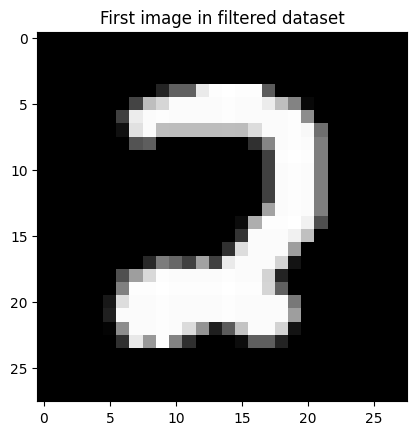

In [4]:
mnist = datasets.MNIST(
    root="../../../datasets/",
    download=True,
    train=True,
)


dataset_size = 200

# randomly sample `dataset_size` indices
sampled_indices = torch.randperm(len(mnist)).tolist()[:dataset_size]

mnist.data = mnist.data[sampled_indices]
mnist.targets = mnist.targets[sampled_indices]


unique_labels = torch.unique(mnist.targets).tolist()
print(f"Labels in dataset: {unique_labels}. \nSize of dataset: {len(mnist)}")

class_7_idx = mnist.targets == 2
dataset_7 = mnist
dataset_7.data = dataset_7.data[class_7_idx]
dataset_7.targets = dataset_7.targets[class_7_idx]

print(f"Shape of image is {dataset_7[0][0].size}")
plt.title("First image in filtered dataset")
plt.imshow(dataset_7[0][0], cmap="gray", vmin=0, vmax=255);  # add ';' to suppress object output for matplotlib 

In [ ]:
def convolutional_block(in_channels: int, out_channels: int) -> nn.Module:
    """
    Returns a block conv-bn-relu-maxpool layer a described in the paper.
    Args:
        in_channels: the number of input channels to the conv layer
        out_channels: the number of output channels from the conv layer
    """

    return nn.Sequential(
        # in the paper 64 out_channels (feature maps) were used with a kernel of size 3x3
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        # in the paper a 2x2 max pooling layer was used
        nn.MaxPool2d(2),
    )


class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            convolutional_block(input_dim, hidden_dim),
            convolutional_block(hidden_dim, hidden_dim),
            convolutional_block(hidden_dim, hidden_dim),
            convolutional_block(hidden_dim, output_dim),
        )

    def forward(self, input: Tensor) -> Tensor:
        output = self.encoder(input)
        output = output.view(output.shape[0], -1)  # flatten last conv layer output
        return output

```{warning}
:class: dropdown
If using Algorithm 1 to implement the loss computation for an episode note that both the 
preprint and the published version of the prototypical networks paper appear to have a typo. 
In Algorithm 1 the prototypes are computed as 

$$
\mathbf{c}_k \leftarrow \frac{1}{N_C} \sum_{(\mathbf{x}_i,y_i)\in S_k} f_\phi(\mathbf{x}_i)
$$

which appears to directly contradict Equation 1 in the paper which divides the sum by the cardinality of the support set (which is correct).

Also not that, likely for clarity, the authors expressed the negative log-softmax loss slightly differently in Algorithm 1 than in Equation 2 using the $\log$ property 

$$
\log(\frac{a}{b}) = \log{(a)} - \log{(b)}
$$
```

In [13]:
class PrototypicalNetworkTrainer:
    def __init__(
        self,
        model: nn.Module,
        device: str,
        learning_rate: float,
        distance_func: callable,
    ):
        self.model = model

        # handle case where device is selected is cuda but no gpu is available
        if torch.cuda.is_available() and device == "cuda":
            self.device = device
        else:
            self.device = "cpu"

        self.model.to(self.device)
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.distance_func = distance_func

    def compute_loss(
        self,
        query_sets: dict[int, Tensor],
        prototypes: dict[int, Tensor],
        num_labels: int,
        n_query_points: int,
        V: list[int]
    ) -> Tensor:
        """
        Computes the loss for prototypical network training which
        is the log softmax where the logits are the negative distances
        of the query point to all `num_labels` class prototypes
        Args:
        
        Returns:
        
        """
        loss = 0
        for k in V:
            for query_point in query_sets[k]:
                # add batch dimension
                input = torch.unsqueeze(query_point, dim=0)
                # compute f_\phi(x)
                embedded_point = self.model(input)

                # compute second term in loss equation
                for label in V:
                    distance = self.distance_func(embedded_point, prototypes[label])
                    loss += torch.exp(-distance)

                loss = torch.log(loss)

                # compute first term in loss equation
                loss += self.distance_func(embedded_point, prototypes[k])

                loss /= (num_labels * n_query_points)
        return loss

    def train(
        self,
        dataset: datasets.VisionDataset,
        num_labels: int,
        n_support_points: int,
        n_query_points: int,
        num_episodes: int,
    ) -> list[float]:
        """
        Args:
            model:
            dataset: The training set, \mathcal{D} in the paper
            num_labels: N_C in the paper
            n_support_points: N_S in the paper
            n_query_points: N_Q in the paper
            num_episodes: the number of episodes to train for
        
        Returns:
            a list of the losses per episode
        """

        print(f"Training device: {self.device}")
        self.model.train()

        # move data to proper device and cast to float and normalize
        dataset.data = dataset.data.float() / 255
        dataset.data = dataset.data.to(self.device)
        dataset.targets = dataset.targets.to(self.device)

        losses = []

        if len(dataset.data.shape) < 4:
            # add color channel dimension after batch dimension if there isn't one (MNIST)
            # assuming dimension 0 is a batch dimension
            dataset.data = torch.unsqueeze(dataset.data, dim=1)

        unique_labels = torch.unique(dataset.targets).tolist()

        for episode in range(num_episodes):
            V = random.sample(unique_labels, num_labels)

            query_sets = {}
            prototypes = {}  # prototypes shape will be 'num classes' x 'embedding dimension'
            for k in V:
                class_indices = dataset.targets == k
                labeled_k = dataset.data[class_indices]
                all_indices = torch.randperm(len(labeled_k)).tolist()

                # randomly sample N_S support examples
                support_indices = all_indices[:n_support_points]
                support_set = labeled_k[support_indices]

                # randomly sample N_Q support examples from set D_{V_k}\S_k (i.e. support examples removed)
                remaining_indices = torch.randperm(
                    len(labeled_k[n_support_points:])
                ).tolist()

                query_indices = remaining_indices[:n_query_points]

                query_sets[k] = labeled_k[query_indices]

                prototypes[k] = torch.sum(self.model(support_set), dim=0)
                prototypes[k] /= n_support_points

            self.optimizer.zero_grad()
            loss = self.compute_loss(query_sets, prototypes, num_labels, n_query_points, V)

            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

        return losses


def squared_euclidean_distance(x: Tensor, y: Tensor) -> float:
    """
    Computes the squared Euclidean distance between two tensors
    Args:
        x: a tensor of size (N,)
        y: a tensor of size (N,)
    Returns:
        The squared Euclidean distance between the two tensors
    """
    return torch.linalg.norm(x - y) ** 2


In [ ]:
model = PrototypicalNetwork(input_dim=1, hidden_dim=64, output_dim=64)

trainer = PrototypicalNetworkTrainer(
    model=model,
    device="cuda",
    learning_rate=1e-3,
    distance_func=squared_euclidean_distance,
)

mnist_dataset = datasets.MNIST(
    root="../../../datasets/",
    download=True,
    train=True,
    transform=transforms.RandomRotation((0, 360)),
)


Training device: cuda


In [ ]:
losses = trainer.train(
    mnist_dataset,
    num_labels=4,
    n_support_points=15,
    n_query_points=15,
    num_episodes=50,
)

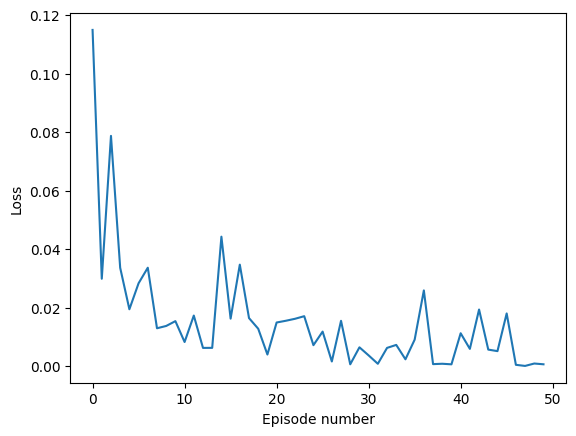

In [19]:
plt.xlabel("Episode number")
plt.ylabel("Loss")
plt.plot(losses)

In [37]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Mon Mar 24 2025

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

torchvision: 0.21.0
matplotlib : 3.7.4
torch      : 2.6.0

